# GOES animation tutorial
A quick tutorial to reporoject GOES-ABI data to new projections

The projection used here was chosen using the excellent projection wizard tool:
    https://projectionwizard.org/#

Note: downloading GOES data using the google cloud api requires you to have GCP service account credentials set up (https://console.cloud.google.com/apis/credentials/serviceaccountkey), and the environment variable GOOGLE_APPLICATION_CREDENTIALS set as the path to your service account key. See https://cloud.google.com/docs/authentication/getting-started for more details

Required modules (from conda):
google-cloud-storage numpy xarray netcdf4 matplotlib opencv pyproj 


In [1]:
import os
import sys
import inspect

import subprocess
from glob import glob
from google.cloud import storage
import warnings

import numpy as np
from numpy import ma
import xarray as xr
from datetime import datetime, timedelta
from pyproj import Proj
import cv2 as cv
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import animation

# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from utils.io import find_abi_files
from utils.abi import get_abi_proj, get_abi_lat_lon

In [2]:
data_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/MCMIPC'

In [3]:
date = datetime(2019,7,1,18)

In [4]:
abi_files = sorted(find_abi_files(date, satellite=16, product='MCMIP', view='C', mode=6, 
                               save_dir=data_path, 
                               replicate_path=True, check_download=True, 
                               n_attempts=1, download_missing=True))
len(abi_files)

12

In [5]:
abi_ds = xr.open_dataset(abi_files[0])
abi_ds

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.128212 ... 0.044268005
  * x                                       (x) float32 -0.101332 ... 0.038612
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    band_wavelength_C02                     (band) float32 ...
    band_wavelength_C03                     (band) float32 ...
    band_wavelength_C04                     (band) float32 ...
    band_wavelength_C05                     (band) float32 ...
    band_wavelength_C06                     (band) float32 ...
    band_wavelength_C07                     (band) float32 ...
    band_wavelength_C08                     (band) float32 ...
    band_wavelength_C09                     (band) float32 ...
    band_wavelength_C10                     (band) float32 ...
    band_wavelength_C11                     (band) float32 ...
    band_wavelength_C12                     (band) float32 ...
    band_wavelength_C13                     (band) float32 ...
    band_wavelength_C14                     (band) float32 ...
    band_wavelength_C15                     (band) float32 ...
    band_wavelength_C16                     (band) float32 ...
    band_id_C01                             (band) int8 ...
    band_id_C02                             (band) int8 ...
    band_id_C03                             (band) int8 ...
    band_id_C04                             (band) int8 ...
    band_id_C05                             (band) int8 ...
    band_id_C06                             (band) int8 ...
    band_id_C07                             (band) int8 ...
    band_id_C08                             (band) int8 ...
    band_id_C09                             (band) int8 ...
    band_id_C10                             (band) int8 ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables:
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    CMI_C04                                 (y, x) float32 ...
    DQF_C04                                 (y, x) float32 ...
    CMI_C05                                 (y, x) float32 ...
    DQF_C05                                 (y, x) float32 ...
    CMI_C06                                 (y, x) float32 ...
    DQF_C06                                 (y, x) float32 ...
    CMI_C07                                 (y, x) float32 ...
    DQF_C07                                 (y, x) float32 ...
    CMI_C08                                 (y, x) float32 ...
    DQF_C08                                 (y, x) float32 ...
    CMI_C09                                 (y, x) float32 ...
    DQF_C09                                 (y, x) float32 ...
    CMI_C10                                 (y, x) float32 ...
    DQF_C10                                 (y, x) float32 ...
    CMI_C11                                 (y, x) float32 ...
    DQF_C11                                 (y, x) float32 ...
    CMI_C12                                 (y, x) float

The ABI data plotted in the original GOES geostationary projection

([], <a list of 0 Text major ticklabel objects>)

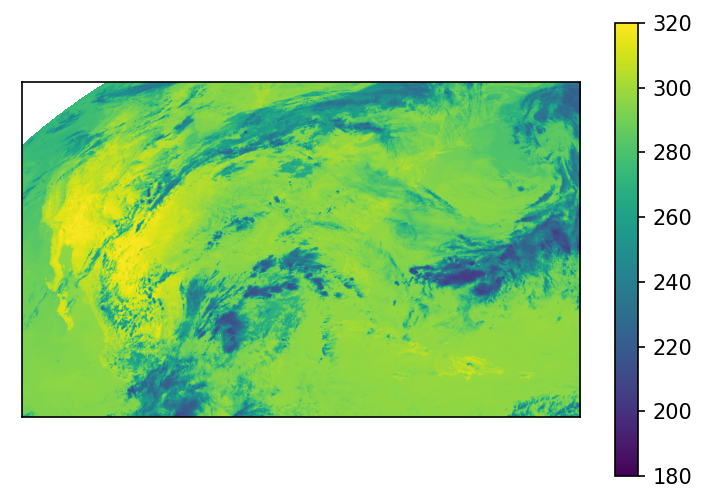

In [6]:
plt.figure(dpi=150)
plt.imshow(abi_ds.CMI_C13, vmin=180, vmax=320)
plt.colorbar()
plt.xticks([])
plt.yticks([])

In [7]:
geo_p = get_abi_proj(abi_ds)

In [8]:
proj_settings='+proj=aea +lon_0=-102.3008685 +lat_1=21.5828509 +lat_2=49.6288881 +lat_0=35.6058695 +datum=WGS84 +units=m +no_defs'
new_p = Proj(proj_settings)

In [9]:
img = abi_ds.CMI_C13.fillna(0).data

In [10]:
class remapper:
    def __init__(self, abi_ds, new_projection, shape=None):
        """
        Reproject a GOES-ABI image to a new perspective:

        Inputs:
        abi_ds -- and xarray dataset object of the abi data file
        new_projection -- a Proj4 projection of the new projection to map to

        Outputs:
        img -- a warped ABI image in the new projection
        """
        if shape is None:
            self.shape = abi_ds.y.shape + abi_ds.x.shape
        else:
            self.shape = shape
        
#       Get limits of the original abi domain in the geostationary projection
        h = abi_ds.goes_imager_projection.perspective_point_height
        min_x = abi_ds.x.min().item() * h 
        max_x = abi_ds.x.max().item() * h 
        min_y = abi_ds.y.min().item() * h 
        max_y = abi_ds.y.max().item() * h 

#       Get lat and lon grids for the abi images
        geo_lats, geo_lons = get_abi_lat_lon(abi_ds)

#       Project these lats and lons into the new projection
        new_x, new_y = new_projection(geo_lons, geo_lats)

#       Create a regular range of x, y coords spanning the new projection
        x_range = np.linspace(new_x[np.isfinite(new_x)].min(), new_x[np.isfinite(new_x)].max(), self.shape[1])
        y_range = np.linspace(new_y[np.isfinite(new_y)].min(), new_y[np.isfinite(new_y)].max(), self.shape[0])

#       Convert the new coords back into the geostationary proejction
        new_geo_x, new_geo_y = geo_p(*new_p(*np.meshgrid(x_range, y_range), inverse=True))

#       Use the limits of the geostationary domain to limit the range to the original pixel indices
        new_geo_x = (new_geo_x - min_x)/(max_x-min_x)*(self.shape[1]-1)
        new_geo_y = (new_geo_y - min_y)/(max_y-min_y)*(self.shape[0]-1)

#       Mask missing values
        self.new_geo_x = ma.array(new_geo_x, mask=np.isinf(new_geo_x), dtype=np.float32)
        self.new_geo_y = ma.array(new_geo_y, mask=np.isinf(new_geo_y), dtype=np.float32)
    
    def __call__(self, img, method='opencv'):
        if method == 'opencv':
            out_img = np.full_like(img, np.nan)
            cv.remap(img[::-1], 
                     self.new_geo_x.filled(-1).astype(np.float32), 
                     self.new_geo_y.filled(-1).astype(np.float32), 
                     cv.INTER_LINEAR, out_img, cv.BORDER_TRANSPARENT)
            return out_img[::-1]
        elif method == 'scipy':
            return interpolate.interpn((np.arange(self.shape[0]), np.arange(self.shape[1])), 
                                       img[::-1], 
                                       (self.new_geo_y.filled(-1), self.new_geo_x.filled(-1)), 
                                       method='linear', 
                                       bounds_error=False, fill_value=np.nan)[::-1]
        else:
            raise ValueError("method must be 'opencv' or 'scipy'")

        

In [11]:
abi_remapper = remapper(abi_ds, new_p)

opencv remap method is a lot faster than scipy interpolation

0:00:00.210344


([], <a list of 0 Text major ticklabel objects>)

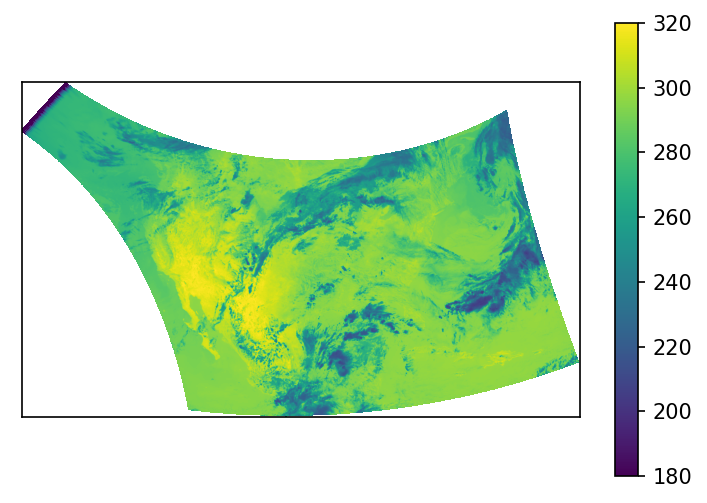

In [12]:
st = datetime.now()
test_opencv = abi_remapper(img)
print(datetime.now()-st)
plt.figure(dpi=150)
plt.imshow(test_opencv, vmin=180, vmax=320)
plt.colorbar()
plt.xticks([])
plt.yticks([])

0:00:01.033486


([], <a list of 0 Text major ticklabel objects>)

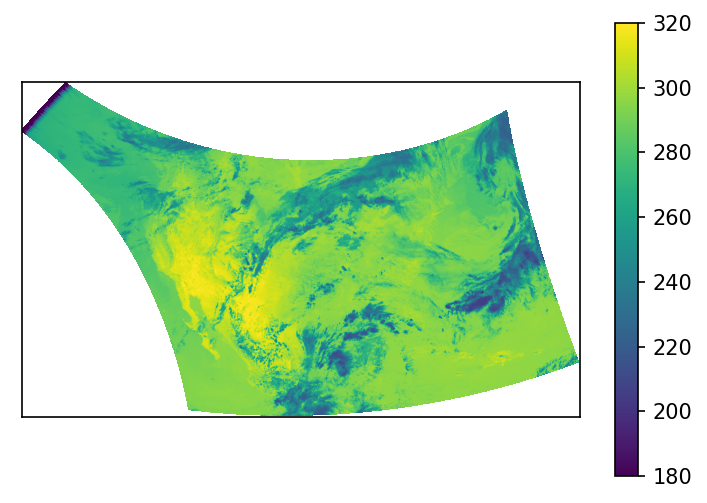

In [13]:
st = datetime.now()
test_scipy = abi_remapper(img, method='scipy')
print(datetime.now()-st)
plt.figure(dpi=150)
plt.imshow(test_scipy, vmin=180, vmax=320)
plt.colorbar()
plt.xticks([])
plt.yticks([])